# Determinación de eventos en ECG (Andrea Lozano)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, lfilter
import wfdb

In [2]:
#Señal tomada con el BITalino para Andrea
#Aqui colocas el txt que deseas leer
txt_f="Paciente_Andrea_L.txt"
ECG_function = open(txt_f,"r")
Data_cruda = ECG_function.read()  # con f.read() leemos todo el contenido
ECG_function.close()
#Datos de la señal
Paciente1="Andrea Lozano"
fs3 = 1000
Ts=1/fs3

[      0       1       2 ... 1803296 1803297 1803298]


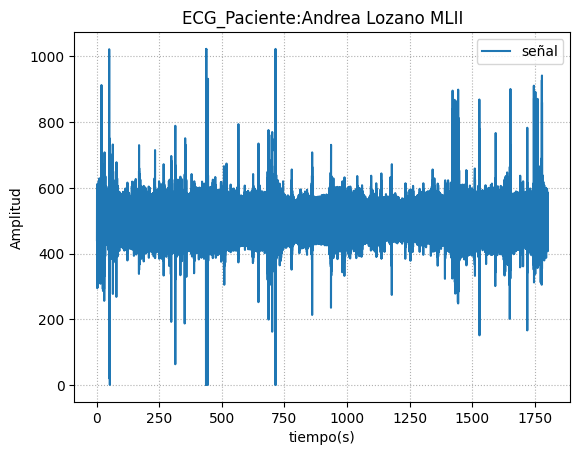

In [3]:
#Lectura
array_ECG = np.genfromtxt(txt_f, delimiter="\t",skip_header = 4)
muestras=array_ECG[:,-2].shape
n=np.arange(0,len(array_ECG))
print(n)
t3=n*Ts

#Figura
plt.figure()
plt.plot(t3,array_ECG[:,-2], label="señal")      # graficamos la señal
plt.grid(linestyle=":")
plt.xlabel("tiempo(s)")
plt.ylabel("Amplitud")
plt.title("ECG_Paciente:"+ Paciente1+" MLII")
plt.legend(loc="upper right")
#plt.xlim([5000,10000])

plt.show()

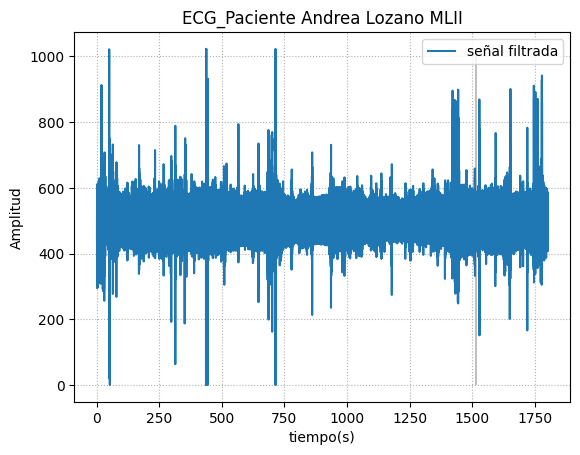

In [4]:
#Delimitación visual del momento de análisis
rect_start = 1513  # Índice de inicio del rectángulo
rect_end = 1520  # Índice de fin del rectángulo


plt.figure()
plt.plot(t3,array_ECG[:,-2], label="señal filtrada")      # graficamos la señal
plt.grid(linestyle=":")
plt.xlabel("tiempo(s)")
plt.ylabel("Amplitud")
plt.title("ECG_Paciente Andrea Lozano MLII")
plt.legend(loc="upper right")

# Creación del rectángulo
rect_width = rect_end - rect_start
rect_height = np.max(array_ECG[:,-2]) - np.min(array_ECG[:,-2])
rect = plt.Rectangle((rect_start, np.min(array_ECG[:,-2])), rect_width, rect_height, facecolor='gray', alpha=0.5)
plt.gca().add_patch(rect)

plt.legend()
plt.show()

Text(0.5, 1.0, 'MLII;female Andrea Lozano 23 años')

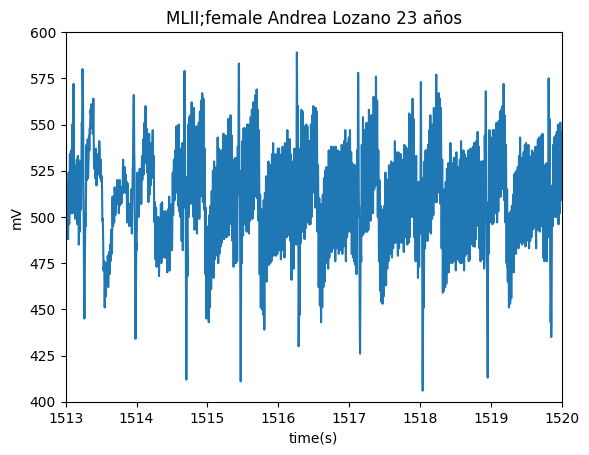

In [5]:
signal_Andrea=array_ECG[:,-2] #Solamente para la derivación MLII
plt.plot(t3,signal_Andrea)
plt.xlim([1513,1520]);plt.xlabel("time(s)");plt.ylabel("mV")
plt.ylim([400,600])
plt.title("MLII;female Andrea Lozano 23 años")

# Detección de momentos de Ruido en la señal

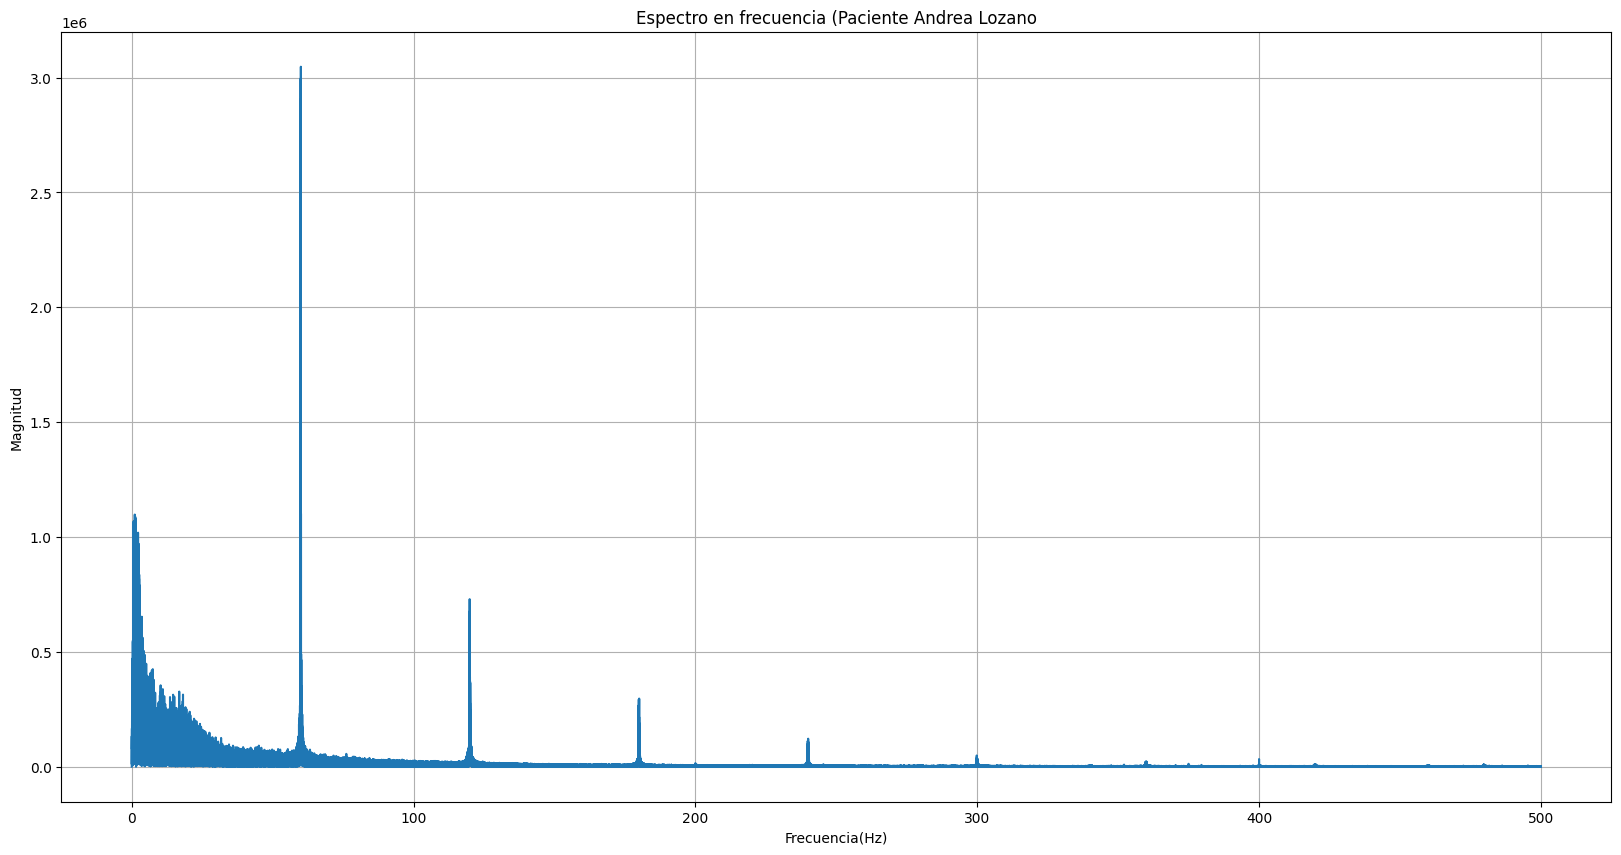

In [6]:
#Elminiación del ruido

# Analizar el Fourier para la primera señal
array_ECG_final=array_ECG[:,-2]- np.mean(array_ECG[:,-2])
N1 = len(array_ECG_final)
yf = np.fft.fft(array_ECG_final,N1)
yf = yf[0:(N1//2)]
yf1 = np.abs(yf)
yf1 = np.round(yf1,3)
F = np.linspace(0, fs3/2, N1//2)
plt.figure(figsize=(20,10))
plt.plot(F,yf1)
plt.grid()
plt.xlabel("Frecuencia(Hz)")
plt.ylabel("Magnitud")
plt.title("Espectro en frecuencia (Paciente Andrea Lozano")
plt.show()

Text(0, 0.5, 'Magnitud')

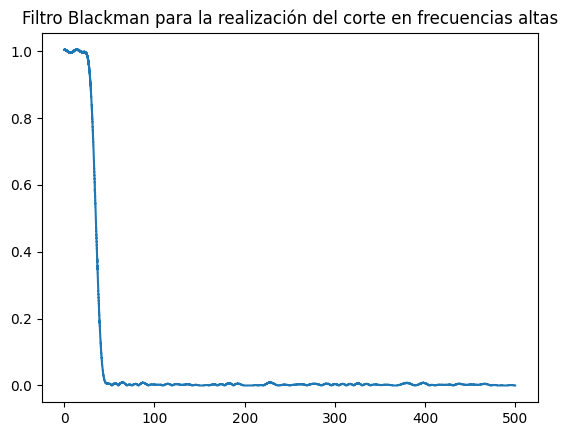

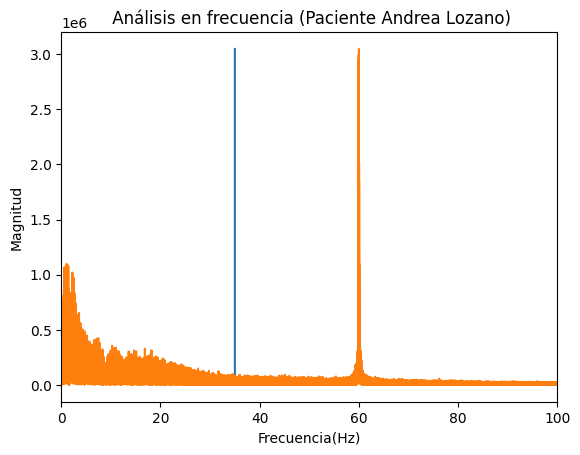

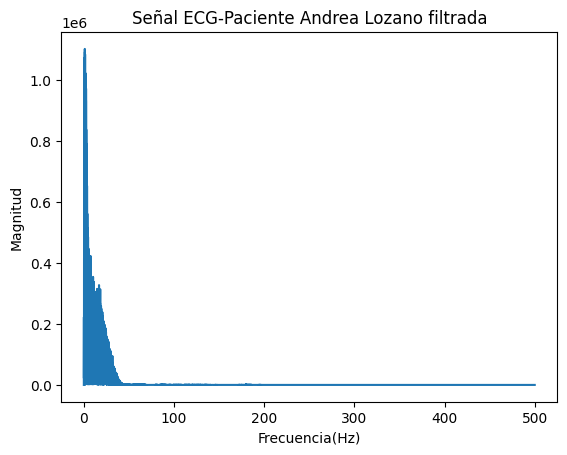

In [7]:
#Evidencia mediante la transformada de Fourier de ruido en 60Hz (Probablemente en sus armónicos también se observe)
#Para el diseño del FIR vamos a incluir el diseño con la ventaba Blackman. Esto se realiza porque la atenuación que genera es mucho mayor que a
#las diferentes ventanas que se aplican

#longitud de la ventana
M = 200

#frecuencia de corte en Hz para elimiar el ruido 60 Hz
Fc = 35 

#Frecuencia de corte en radianes
wc = 2*np.pi*Fc/fs3

# filtro fir
w = firwin(numtaps=M, cutoff=Fc, window='blackman', fs=fs3)
w = np.round(w,3)
nm = np.arange(M)
W = np.fft.fft(w,N1)
W = np.round(W[0:N1//2],3)


#magnitud
Wm = np.abs(W)
Rx = Fc*np.ones([N1//2])
Ry = np.linspace(0,1,N1//2)
Ry = np.linspace(0,np.max(yf1),N1//2) #el eje y

plt.figure()
plt.plot(F,Wm)
plt.title("Filtro Blackman para la realización del corte en frecuencias altas")

plt.figure()
plt.plot(Rx,Ry)
plt.plot(F,yf1)
plt.xlim([0,100])
#plt.ylim([0,0.125*1e6])
plt.title(" Análisis en frecuencia (Paciente Andrea Lozano)")
plt.xlabel("Frecuencia(Hz)")
plt.ylabel("Magnitud")

#Aplicación del filtro

Sf = lfilter(w, np.array(1),array_ECG_final)

# Se hace la conversión a Frecuencia 
Sff = np.fft.fft(Sf,N1)
Sff = Sff[0:(N1//2)]
Sff1 = np.abs(Sff)
Sff1 = np.round(Sff1,3)
plt.figure()
plt.plot(F,Sff1)
plt.title("Señal ECG-Paciente Andrea Lozano filtrada")
plt.xlabel("Frecuencia(Hz)")
plt.ylabel("Magnitud")

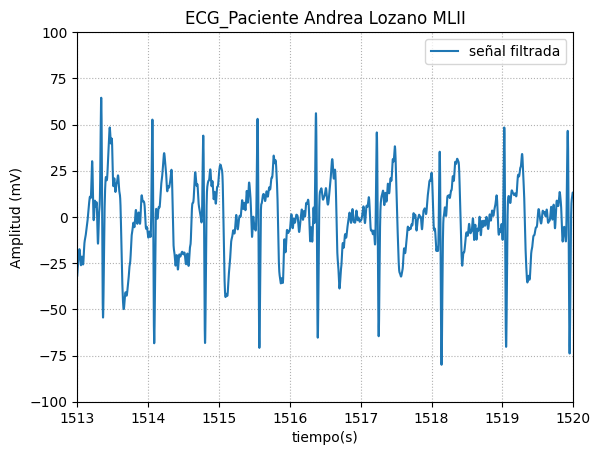

In [8]:
#Reconstrucción de la señal para la paciente 106
plt.figure()
plt.plot(t3,Sf, label="señal filtrada")      # graficamos la señal
plt.grid(linestyle=":")
plt.xlabel("tiempo(s)")
plt.ylabel("Amplitud (mV)")
plt.title("ECG_Paciente Andrea Lozano MLII")
plt.legend(loc="upper right")
plt.xlim([1513,1520])
#plt.ylim([-100,100])
plt.ylim([-100,100])
plt.show()

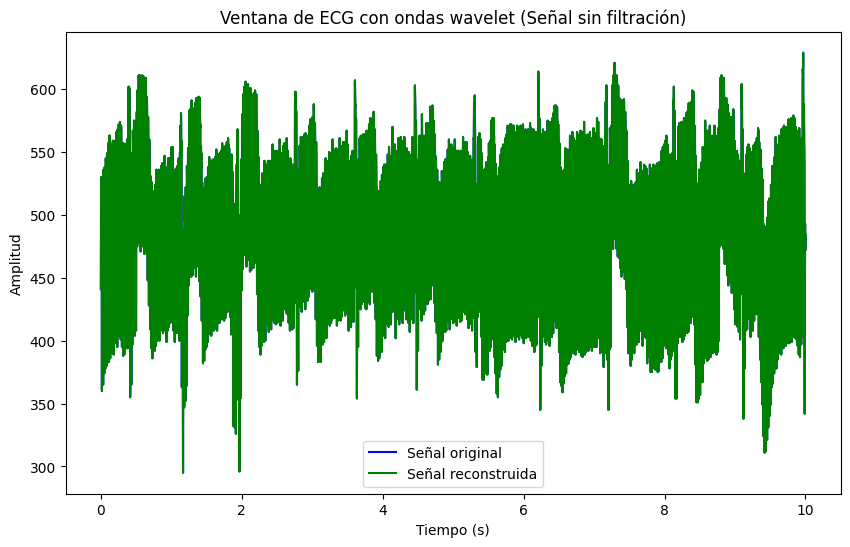

In [9]:
#Visualización de la señal por segmentación mediante ventana Wavelet
#Creación de ondas Wavelet
import pywt

#Para la señal original (Visualización del ruido)

window_duration = 10  # Duración de la ventana en segundos
window_samples = int(window_duration * fs3)
ecg_window = signal_Andrea[:window_samples]

# Obtener los coeficientes wavelet utilizando la transformada wavelet
wavelet = 'db4'  # Tipo de onda wavelet a utilizar (puedes elegir otro según tus necesidades)
coeffs = pywt.wavedec(ecg_window, wavelet)

# Reconstruir la señal a partir de los coeficientes wavelet (si es necesario)
reconstructed_ecg = pywt.waverec(coeffs, wavelet)

# Graficar la señal original y la señal reconstruida
time = np.arange(window_samples) / fs3

plt.figure(figsize=(10, 6))
plt.plot(time, ecg_window,label='Señal original',color="blue")
plt.plot(time, reconstructed_ecg, label='Señal reconstruida',color="green")
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Ventana de ECG con ondas wavelet (Señal sin filtración)')
plt.legend()
plt.show()

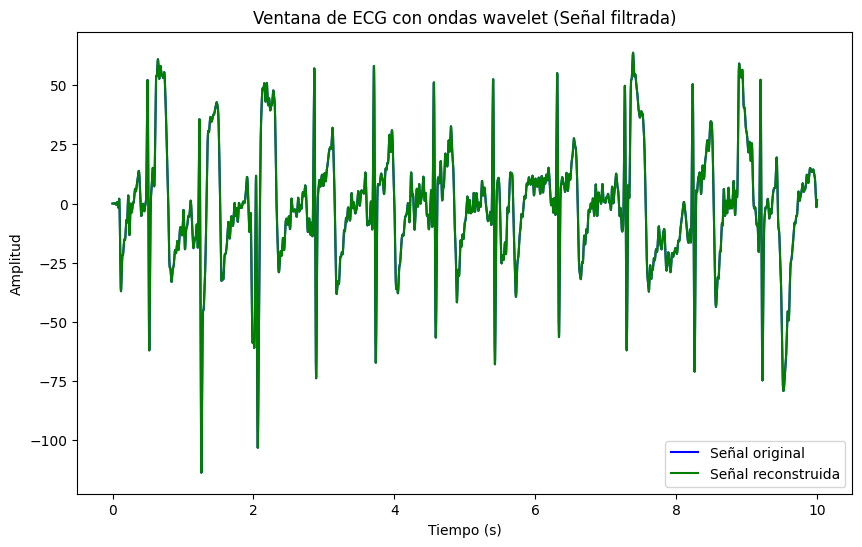

In [10]:
window_duration = 10  # Duración de la ventana en segundos
window_samples = int(window_duration * fs3)
ecg_window = Sf[:window_samples]

# Obtener los coeficientes wavelet utilizando la transformada wavelet
wavelet = 'db4'  # Tipo de onda wavelet a utilizar (puedes elegir otro según tus necesidades)
coeffs = pywt.wavedec(ecg_window, wavelet)

# Reconstruir la señal a partir de los coeficientes wavelet (si es necesario)
reconstructed_ecg = pywt.waverec(coeffs, wavelet)

# Graficar la señal original y la señal reconstruida
time = np.arange(window_samples) / fs3

plt.figure(figsize=(10, 6))
plt.plot(time, ecg_window,label='Señal original',color="blue")
plt.plot(time, reconstructed_ecg, label='Señal reconstruida',color="green")
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Ventana de ECG con ondas wavelet (Señal filtrada)')
plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

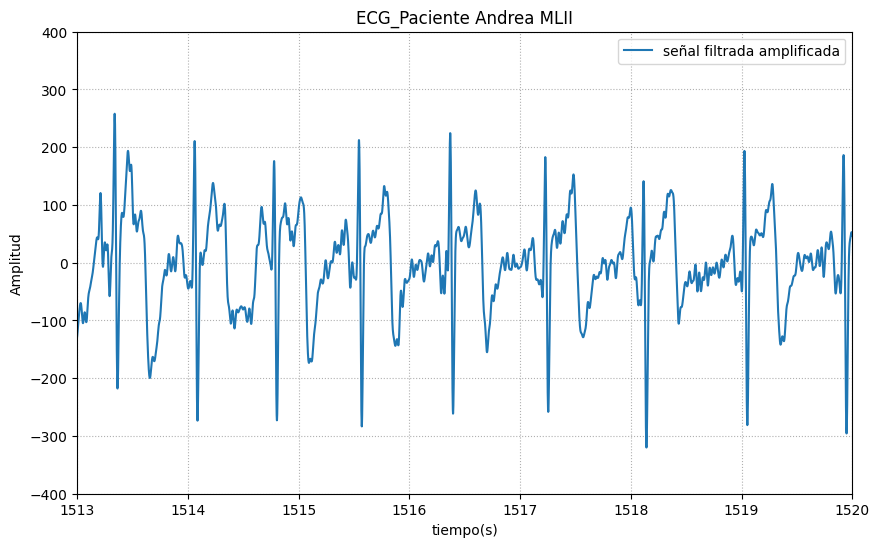

In [11]:
#Siempre podemos amplificar la señal para mejorar los fines de la aplicación
factor_ampl=4
Sf_ampl= Sf*factor_ampl

plt.figure()
plt.figure(figsize=(10, 6))
plt.plot(t3 ,Sf_ampl, label="señal filtrada amplificada")      # graficamos la señal
plt.grid(linestyle=":")
plt.xlabel("tiempo(s)")
plt.ylabel("Amplitud")
plt.title("ECG_Paciente Andrea MLII")
plt.legend(loc="upper right")
plt.xlim([1513,1520])
plt.ylim([-100*factor_ampl,100*factor_ampl])
plt.show()

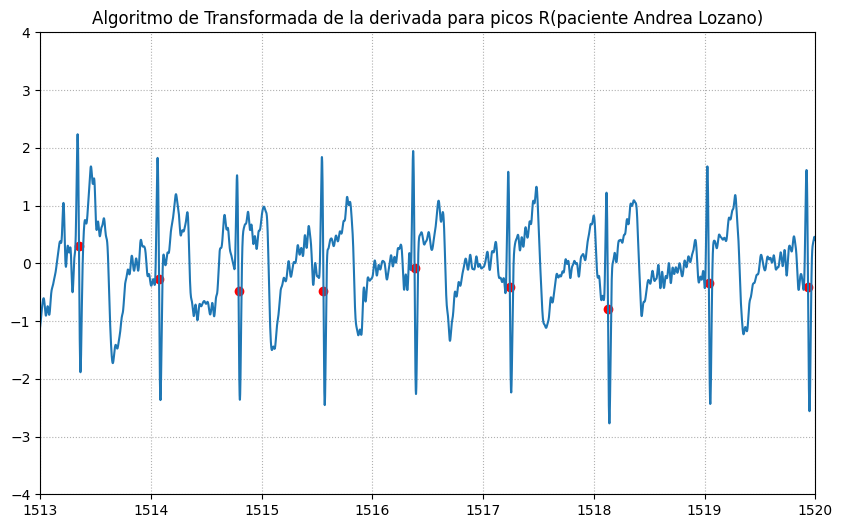

In [30]:
# Normalización
from scipy.signal import find_peaks
norm_ecg = Sf_ampl / np.std(Sf_ampl)
# Calcula la derivada de primer orden de la señal
ecg_derivative = np.gradient(norm_ecg)
# Obtiene el valor absoluto de la derivada
ecg_derivative_abs = np.abs(ecg_derivative)
# Calcula un umbral como un porcentaje del valor máximo de la señal derivada
threshold = 0.15 * np.max(ecg_derivative_abs)
# Encuentra los índices de los picos que superen el umbral definido
r_peaks_indices, _ = find_peaks(ecg_derivative_abs, height=threshold)

# Grafica la señal de ECG
plt.figure(figsize=(10, 6))
plt.plot(t3,norm_ecg)
plt.title("Algoritmo de Transformada de la derivada para picos R(paciente Andrea Lozano)")
# Marca los picos R en la señal
plt.scatter(r_peaks_indices/fs3, norm_ecg[r_peaks_indices], color='red', marker='o')
plt.xlim([1513,1520])
plt.grid(linestyle=":")
plt.ylim([-4,4])
# Muestra la gráfica
plt.show()

In [31]:
#Es importante resaltar que la aplicación del algoritmo de la transformada de la derivada también puede complementarse con el algoritmo
#De Pan-Tompinks que incluye los pasos de elevación al cuadrado de la señal y filtración con pasabajos posterior.

#Se puede detectar la diferencia de tiempos entre los cuales se realiza la aparición de los picos R para estimar alteraciones
#de la frecuencia cardiaca
rr_intervals = np.diff(r_peaks_indices) /fs3  # Diferencia entre los tiempos de picos R consecutivos, convertidos a segundos


# Identificar arritmias basadas en los intervalos RR
arrhythmias = []

# Ejemplo: detectar arritmia si hay una diferencia de más 0.9 segundos
rr_threshold = 0.9  # Umbral de diferencia entre intervalos RR

for i in range(1, len(rr_intervals)):
    diff_ratio = abs(rr_intervals[i] - rr_intervals[i-1]) / rr_intervals[i-1]
    if diff_ratio > rr_threshold:
        arrhythmias.append(i)

# Imprimir los índices de las muestras con arritmias
print("Muestras con arritmias:", arrhythmias)

Muestras con arritmias: [12, 14, 15, 16, 18, 19, 20, 22, 24, 25, 26, 33, 35, 52, 53, 54, 56, 57, 58, 61, 63, 65, 66, 67, 68, 69, 71, 72, 73, 78, 79, 81, 82, 83, 84, 87, 88, 89, 90, 92, 93, 94, 96, 97, 99, 104, 105, 107, 108, 109, 110, 111, 112, 114, 115, 116, 117, 118, 128, 129, 131, 132, 135, 136, 139, 140, 142, 143, 147, 148, 186, 187, 188, 189, 190, 191, 192, 193, 212, 213, 215, 216, 223, 224, 225, 226, 236, 238, 243, 244, 254, 255, 256, 257, 258, 260, 261, 263, 264, 265, 266, 268, 270, 271, 275, 284, 285, 287, 289, 290, 294, 301, 302, 304, 305, 315, 316, 321, 325, 329, 330, 333, 338, 339, 340, 341, 349, 358, 359, 360, 361, 363, 364, 385, 387, 390, 391, 393, 395, 396, 398, 399, 400, 401, 403, 405, 406, 407, 410, 411, 412, 413, 416, 418, 420, 422, 423, 428, 429, 430, 432, 433, 434, 435, 437, 441, 442, 443, 445, 446, 447, 448, 449, 450, 451, 452, 454, 457, 459, 462, 463, 465, 466, 467, 470, 471, 473, 474, 476, 477, 478, 480, 481, 482, 483, 485, 486, 487, 488, 489, 490, 491, 492, 493, 

In [42]:
# Definir ventana de búsqueda de la onda P (previa al pico R)
#Buscamos establecer los tiempos de inicio de la onda P previa al pico R
def Det_arritmias1(signal,r_peaks_times,momentos):

    # Definir ventana de búsqueda de la onda P (previa al pico R)
    window_start = -0.15  # Inicio de la ventana relativo al pico R (aquí se usa 150 ms antes)
    window_end = -0.04  # Fin de la ventana relativo al pico R (aquí se usa 40 ms antes)

    # Inicializar listas para almacenar los tiempos y amplitudes de las ondas P
    p_wave_times = []
    p_wave_amplitudes = []

    # Recorrer todos los tiempos de los picos R y buscar la onda P en la ventana definida
    for r_peak_time in r_peaks_times:
        window_times = np.arange(r_peak_time + window_start, r_peak_time + window_end, dt)
        window_ecg_signal = np.interp(window_times, np.arange(0, len(signal)) * dt, signal)

        # Encontrar el índice del máximo en la ventana
        max_index = np.argmax(window_ecg_signal)

        # Añadir el tiempo y la amplitud correspondiente a la onda P
        p_wave_time = window_times[max_index]
        p_wave_amplitude = window_ecg_signal[max_index]
        p_wave_times.append(p_wave_time)
        p_wave_amplitudes.append(p_wave_amplitude)

    # Identificar arritmias basadas en las características de las ondas P
    arrhythmias = []

    # Ejemplo: detectar arritmia si la amplitud de la onda P es menor que un umbral
    amplitude_threshold = 0.1  # Umbral de amplitud para detectar arritmia

    for i, amplitude in enumerate(p_wave_amplitudes):
        if amplitude < amplitude_threshold:
            arrhythmias.append(p_wave_times[i])

    # Graficar el ECG con las ondas P y las arritmias marcadas
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(0, len(signal)) * dt, signal, label='ECG')
    plt.xlim(momentos)
    plt.scatter(p_wave_times, p_wave_amplitudes, color='green', label='Ondas P')
    plt.scatter(arrhythmias, np.interp(arrhythmias, np.arange(0, len(signal)) * dt, signal), color='purple', label='Arritmias')
    plt.ylim([-400,400])
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.title('Detección de arritmias en ECG')
    plt.legend()
    plt.show()

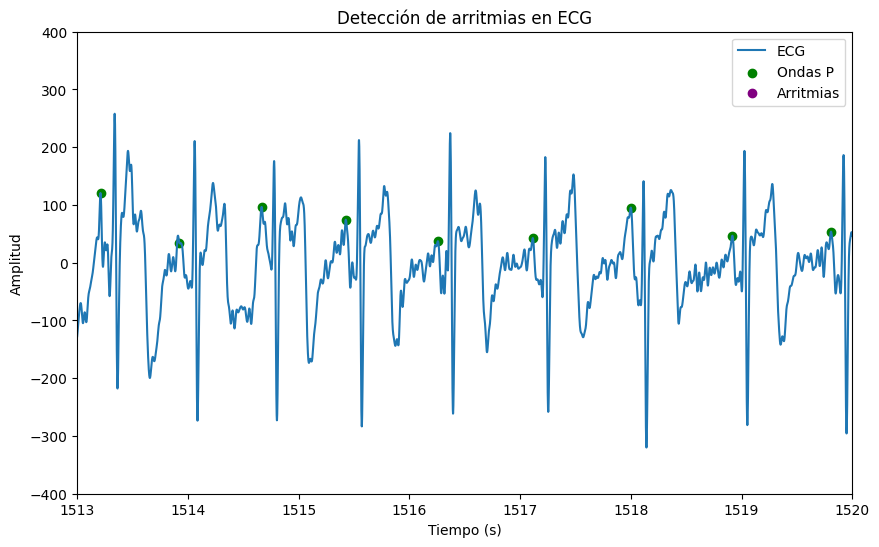

In [43]:
dt=1/fs3
momentos=[1513,1520]
Det_arritmias1(Sf_ampl,r_peaks_indices/fs3,momentos)

In [16]:
#Hallamos los picos R para luego determinar la posible presencia de ritmos inusuales (alteración de la frecuencia cardiaca)
#La detección de los picos R se realizará mediante la transformada de la derivada
from scipy.signal import find_peaks